In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [7]:
 #!/bin/bash
!kaggle datasets download ismailpromus/skin-diseases-image-dataset

Dataset URL: https://www.kaggle.com/datasets/ismailpromus/skin-diseases-image-dataset
License(s): copyright-authors
100% 5.18G/5.19G [01:03<00:00, 59.2MB/s]
100% 5.19G/5.19G [01:03<00:00, 87.3MB/s]


In [8]:
import zipfile

zip_ref = zipfile.ZipFile('/content/skin-diseases-image-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()


In [9]:
!pip install split_folders

In [10]:
import os
import random
import shutil
import numpy as np
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_DIR = '/content/IMG_CLASSES'        # Input folder with original classes
OUTPUT_DIR = '/content/dataset_split'   # Final dataset output

TARGET_TOTAL_COUNT = 7000
TARGET_TRAIN_COUNT = 5000
TARGET_VAL_COUNT = TARGET_TOTAL_COUNT - TARGET_TRAIN_COUNT

# Oversample to reach 7000
def oversampler(class_name, class_count, target=7000, batch_size=32, target_size=(240, 240)):
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    curr_dir = os.path.join(IMG_DIR, class_name)
    save_dir = curr_dir

    images = os.listdir(curr_dir)
    images = [os.path.join(curr_dir, img) for img in images]
    cnt = class_count

    while cnt < target:
        batch_images = []
        for img_path in random.sample(images, batch_size):
            img = Image.open(img_path).convert("RGB")
            img = img.resize(target_size)
            img = np.array(img)
            batch_images.append(img)

        batch_images = np.array(batch_images)

        for _ in datagen.flow(batch_images, batch_size=batch_size, save_to_dir=save_dir, save_prefix='aug', save_format='jpg'):
            cnt += batch_size
            if cnt >= target:
                break

        print(f"🟢 Oversampled {cnt}/{target} images for {class_name}")

# Undersample to exactly 7000
def undersampler(class_name, class_count, target_count=7000):
    curr_dir = os.path.join(IMG_DIR, class_name)
    images = os.listdir(curr_dir)
    images_to_delete = random.sample(images, class_count - target_count)

    for image in images_to_delete:
        img_path = os.path.join(curr_dir, image)
        try:
            os.remove(img_path)
        except Exception as e:
            print(f"❌ Error deleting {img_path}: {e}")

    print(f"🔻 Deleted {len(images_to_delete)} images for {class_name}")

# Main split function
def balance_and_split():
    # Clean previous output
    if os.path.exists(OUTPUT_DIR):
        shutil.rmtree(OUTPUT_DIR)
    os.makedirs(f'{OUTPUT_DIR}/train', exist_ok=True)
    os.makedirs(f'{OUTPUT_DIR}/val', exist_ok=True)

    for class_name in os.listdir(IMG_DIR):
        class_path = os.path.join(IMG_DIR, class_name)
        if not os.path.isdir(class_path):
            continue

        print(f"\n📂 Processing class: {class_name}")
        all_images = os.listdir(class_path)
        count = len(all_images)

        # First balance to exactly 7000
        if count < TARGET_TOTAL_COUNT:
            oversampler(class_name, count, target=TARGET_TOTAL_COUNT)
        elif count > TARGET_TOTAL_COUNT:
            undersampler(class_name, count, target_count=TARGET_TOTAL_COUNT)

        # Reload after balancing
        all_images = os.listdir(class_path)
        random.shuffle(all_images)

        # Split 5000 train / 2000 val
        train_imgs = all_images[:TARGET_TRAIN_COUNT]
        val_imgs = all_images[TARGET_TRAIN_COUNT:TARGET_TOTAL_COUNT]

        os.makedirs(f'{OUTPUT_DIR}/train/{class_name}', exist_ok=True)
        os.makedirs(f'{OUTPUT_DIR}/val/{class_name}', exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(OUTPUT_DIR, 'train', class_name, img))
        for img in val_imgs:
            shutil.copy(os.path.join(class_path, img), os.path.join(OUTPUT_DIR, 'val', class_name, img))

        print(f"✅ {class_name}: 5000 train, 2000 val")

# Run
balance_and_split()



📂 Processing class: 10. Warts Molluscum and other Viral Infections - 2103
🟢 Oversampled 7031/7000 images for 10. Warts Molluscum and other Viral Infections - 2103
✅ 10. Warts Molluscum and other Viral Infections - 2103: 5000 train, 2000 val

📂 Processing class: 2. Melanoma 15.75k
🟢 Oversampled 7012/7000 images for 2. Melanoma 15.75k
✅ 2. Melanoma 15.75k: 5000 train, 2000 val

📂 Processing class: 6. Benign Keratosis-like Lesions (BKL) 2624
🟢 Oversampled 7007/7000 images for 6. Benign Keratosis-like Lesions (BKL) 2624
✅ 6. Benign Keratosis-like Lesions (BKL) 2624: 5000 train, 2000 val

📂 Processing class: 5. Melanocytic Nevi (NV) - 7970
🔻 Deleted 970 images for 5. Melanocytic Nevi (NV) - 7970
✅ 5. Melanocytic Nevi (NV) - 7970: 5000 train, 2000 val

📂 Processing class: 3. Atopic Dermatitis - 1.25k
🟢 Oversampled 7017/7000 images for 3. Atopic Dermatitis - 1.25k
✅ 3. Atopic Dermatitis - 1.25k: 5000 train, 2000 val

📂 Processing class: 7. Psoriasis pictures Lichen Planus and related disease

In [11]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.applications import EfficientNetB7
from keras.callbacks import ReduceLROnPlateau
from keras.utils import image_dataset_from_directory
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization

# Define image size and batch size
img_size = (256, 256)
batch_size = 32

# Paths to train and validation datasets (as defined in the previous steps)
train_path = '/content/dataset_split/train'
val_path = '/content/dataset_split/val'

# Create the train dataset
train_dataset = image_dataset_from_directory(
    train_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=123,
    label_mode = 'categorical'
)

# Get the class names from the training dataset
class_names = train_dataset.class_names

# Create the validation dataset
val_dataset = image_dataset_from_directory(
    val_path,
    image_size=img_size,
    batch_size=batch_size,
    seed=42,
    label_mode = 'categorical'
)

# Display class names (optional)
print("Class Names:", class_names)

Found 50000 files belonging to 10 classes.
Found 19820 files belonging to 10 classes.
Class Names: ['1. Eczema 1677', '10. Warts Molluscum and other Viral Infections - 2103', '2. Melanoma 15.75k', '3. Atopic Dermatitis - 1.25k', '4. Basal Cell Carcinoma (BCC) 3323', '5. Melanocytic Nevi (NV) - 7970', '6. Benign Keratosis-like Lesions (BKL) 2624', '7. Psoriasis pictures Lichen Planus and related diseases - 2k', '8. Seborrheic Keratoses and other Benign Tumors - 1.8k', '9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k']


In [ ]:
import numpy as np
from collections import defaultdict

# Helper function to count class distribution
def get_class_distribution(dataset, class_names):
    class_counts = defaultdict(int)
    for images, labels in dataset.unbatch():
        label = labels.numpy()
        if isinstance(label, np.ndarray):
            # Handle categorical labels
            label = np.argmax(label)
        class_counts[label] += 1

    # Print nicely
    print("Class distribution:")
    for idx, count in sorted(class_counts.items()):
        print(f"{class_names[idx]}: {count}")

# Check training set
print("\nTraining set class distribution:")
get_class_distribution(train_dataset, class_names)

# Check validation set
print("\nValidation set class distribution:")
get_class_distribution(val_dataset, class_names)



Training set class distribution:
Class distribution:
1. Eczema 1677: 5000
10. Warts Molluscum and other Viral Infections - 2103: 5000
2. Melanoma 15.75k: 5000
3. Atopic Dermatitis - 1.25k: 5000
4. Basal Cell Carcinoma (BCC) 3323: 5000
5. Melanocytic Nevi (NV) - 7970: 5000
6. Benign Keratosis-like Lesions (BKL) 2624: 5000
7. Psoriasis pictures Lichen Planus and related diseases - 2k: 5000
8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 5000
9. Tinea Ringworm Candidiasis and other Fungal Infections - 1.7k: 5000

Validation set class distribution:
Class distribution:
1. Eczema 1677: 1975
10. Warts Molluscum and other Viral Infections - 2103: 1995
2. Melanoma 15.75k: 1992
3. Atopic Dermatitis - 1.25k: 1956
4. Basal Cell Carcinoma (BCC) 3323: 1984
5. Melanocytic Nevi (NV) - 7970: 2000
6. Benign Keratosis-like Lesions (BKL) 2624: 1971
7. Psoriasis pictures Lichen Planus and related diseases - 2k: 1971
8. Seborrheic Keratoses and other Benign Tumors - 1.8k: 1981
9. Tinea Ringworm Can

In [12]:
import tensorflow as tf
# Preprocessing function
@tf.function
def preprocess_image(image, label):
    # Resize the image
    image = tf.image.resize(image, [256, 256])
    # Apply EfficientNet preprocessing
    image = tf.keras.applications.efficientnet.preprocess_input(image)
    return image, label

# Apply the preprocessing pipeline to the datasets
train_dataset = train_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(preprocess_image).prefetch(tf.data.AUTOTUNE)

In [13]:
from keras.applications.efficientnet import preprocess_input



# Feature extractor
base_model = tf.keras.applications.EfficientNetB3(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet',
    pooling='max'
)

for layer in base_model.layers:
    layer.trainable = False

# Build model
inputs = base_model.input
x = BatchNormalization()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Flatten()(x)
outputs = Dense(10, activation='softmax')(x) #output layer
model = Model(inputs=inputs, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Define early stopping and learning rate reduction callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10,
    callbacks=[early_stopping, lr_reduction]
)

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 296s 163ms/step - accuracy: 0.6777 - loss: 0.8852 - val_accuracy: 0.8623 - val_loss: 0.3777 - learning_rate: 0.0010
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 210s 134ms/step - accuracy: 0.8456 - loss: 0.4300 - val_accuracy: 0.8747 - val_loss: 0.3603 - learning_rate: 0.0010
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 231s 147ms/step - accuracy: 0.8642 - loss: 0.3751 - val_accuracy: 0.8835 - val_loss: 0.3314 - learning_rate: 0.0010
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 239s 133ms/step - accuracy: 0.8742 - loss: 0.3495 - val_accuracy: 0.8883 - val_loss: 0.3257 - learning_rate: 0.0010
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 285s 148ms/step - accuracy: 0.8877 - loss: 0.3158 - val_accuracy: 0.8837 - val_loss: 0.3387 - learning_rate: 0.0010
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 208s 133ms/step - accuracy: 0.8970 - loss: 0.2888 - val_accuracy: 0.8902 - val_loss: 0.3417 - learning_rate: 0.0010
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 233s 149ms

In [18]:
import numpy as np
from sklearn.metrics import classification_report

y_true = []
y_pred_classes = []

for images, labels in val_dataset:
    preds = model.predict(images)
    y_pred_classes.extend(np.argmax(preds, axis=1))
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot to int

# Convert to arrays
y_true = np.array(y_true)
y_pred_classes = np.array(y_pred_classes)

# Generate classification report
report = classification_report(
    y_true,
    y_pred_classes,
    target_names=class_names,
    zero_division=0
)

print("Classification Report:\n")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0

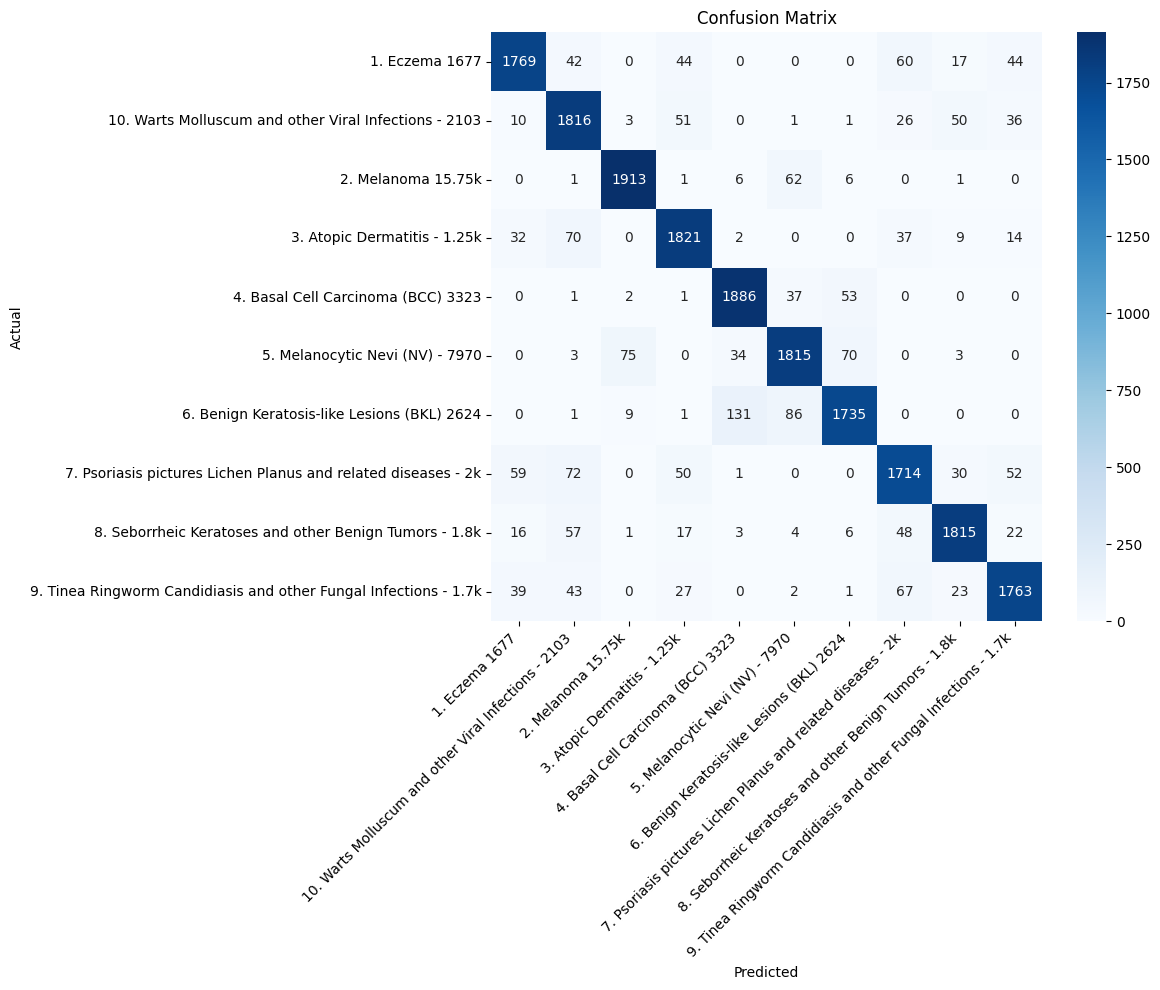

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [22]:
from sklearn.metrics import precision_score

# Overall precision (macro average)
precision_macro = precision_score(y_true, y_pred_classes, average='macro')

# Overall precision (weighted average)
precision_weighted = precision_score(y_true, y_pred_classes, average='weighted')

print(f"Macro Precision: {precision_macro:.4f}")
print(f"Weighted Precision: {precision_weighted:.4f}")


Macro Precision: 0.9109
Weighted Precision: 0.9109


In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
from tensorflow.keras.models import load_model

model.save("/content/drive/MyDrive/final_model/final_model1.keras")

In [23]:
for images, labels in val_dataset.take(1):
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    true_classes = np.argmax(labels.numpy(), axis=1)
    print("Predicted:", pred_classes)
    print("True labels:", true_classes)
    break


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Predicted: [1 3 5 3 4 8 3 0 6 8 1 7 6 7 1 5 2 7 1 9 5 4 9 3 3 1 6 5 6 7 8 3]
True labels: [1 3 5 3 4 8 3 0 6 8 1 7 6 7 1 4 2 7 1 9 5 4 9 3 3 1 6 5 6 9 8 0]
